
=== Experiment A: WITHOUT PCA (full features) ===
SVM (full)  - Accuracy: 0.7809, F1: 0.7234
LR  (full)  - Accuracy: 0.8090, F1: 0.7606


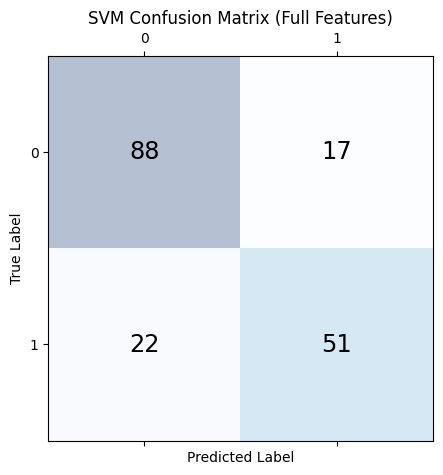

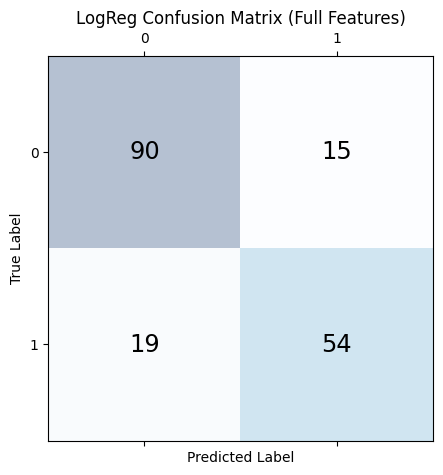


=== Experiment B: WITH PCA (k=3) ===
PCA: Selected 3 components explaining 63.69% variance.


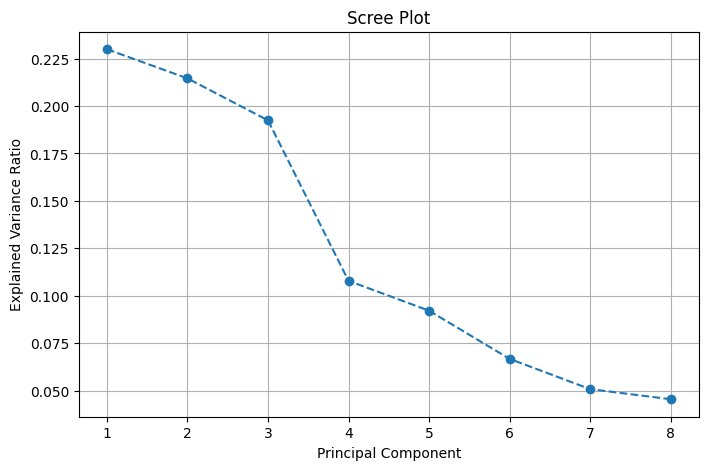

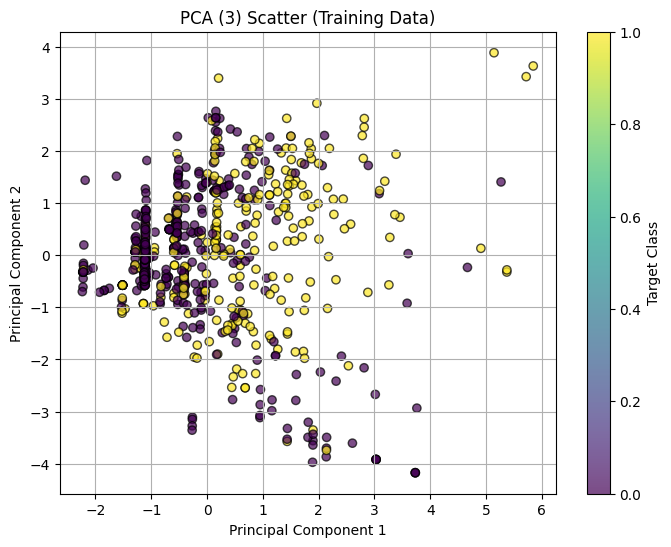

SVM (PCA3) - Accuracy: 0.7135, F1: 0.5641
LR  (PCA3) - Accuracy: 0.7303, F1: 0.6250


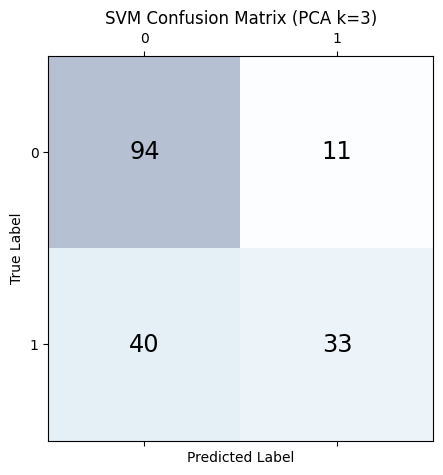

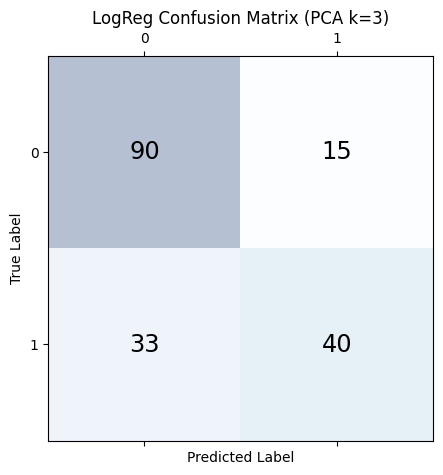


=== Summary (Test set) ===
Model                  Accuracy   F1        
--------------------------------------------
SVM (full)             0.7809     0.7234    
SVM (PCA k=3)          0.7135     0.5641    
LR (full)              0.8090     0.7606    
LR (PCA k=3)           0.7303     0.6250    


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# 1. Helper Functions (Splitting & Scaling)
# ==========================================

def train_test_split_manual(X, y, test_size=0.2, random_state=42):
    """Splits data into training and testing sets."""
    np.random.seed(random_state)
    indices = np.random.permutation(len(X))
    test_samples = int(len(X) * test_size)
    test_idx = indices[:test_samples]
    train_idx = indices[test_samples:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

def standardize_manual(X_train, X_test):
    """Standardizes features by removing the mean and scaling to unit variance."""
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)
    std = np.where(std == 0, 1, std)
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def f1_score_manual(y_true, y_pred):
    """Calculates F1 Score = 2 * (Precision * Recall) / (Precision + Recall)"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    if (precision + recall) == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def confusion_matrix_manual(y_true, y_pred):
    """Returns 2x2 confusion matrix [[TN, FP], [FN, TP]]"""
    tp = np.sum((y_true == 1) & (y_pred == 1))
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    return np.array([[tn, fp], [fn, tp]])


# ==========================================
# 2. PCA Implementation from Scratch (supports n_components)
# ==========================================

class PCA_Scratch:
    """
    PCA implementation that:
      - accepts variance_threshold (float in (0,1]) OR n_components (int)
      - sets: components (shape: n_components x n_features), mean, n_components
      - also sets sklearn-like: explained_variance_ and explained_variance_ratio_
    """
    def __init__(self, variance_threshold=0.95, n_components=None):
        self.variance_threshold = variance_threshold
        self.requested_n_components = n_components
        self.components = None   # shape: (n_components, n_features)
        self.mean = None
        self.n_components = None
        self.explained_variance_ = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=float)
        if X.ndim != 2:
            raise ValueError("X must be 2D array")

        # 1. Mean centering
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean

        # 2. Covariance matrix
        cov = np.cov(X_centered, rowvar=False)

        # 3. Eigen decomposition (use eigh for symmetric matrix)
        eigvals, eigvecs = np.linalg.eigh(cov)  # ascending order

        # 4. Sort eigenvalues & eigenvectors descending
        idxs = np.argsort(eigvals)[::-1]
        eigvals = eigvals[idxs]
        eigvecs = eigvecs[:, idxs]   # columns are eigenvectors

        # 5. Explained variance ratio (all components)
        total_variance = np.sum(eigvals)
        if total_variance <= 0:
            explained_variance_ratio_all = np.zeros_like(eigvals)
        else:
            explained_variance_ratio_all = eigvals / total_variance

        # 6. Determine number of components to keep:
        if self.requested_n_components is not None:
            if not (1 <= int(self.requested_n_components) <= eigvals.shape[0]):
                raise ValueError("n_components must be between 1 and n_features")
            k = int(self.requested_n_components)
        else:
            vt = 1.0 if self.variance_threshold is None else float(self.variance_threshold)
            if not (0 < vt <= 1):
                raise ValueError("variance_threshold must be in (0, 1]")
            cumulative = np.cumsum(explained_variance_ratio_all)
            k = int(np.searchsorted(cumulative, vt, side='left') + 1)
            k = min(k, eigvals.shape[0])

        self.n_components = k

        # 7. Store components as (k, n_features)
        self.components = eigvecs[:, :k].T.copy()  # rows = components

        # 8. Store explained variance info (full vectors)
        self.explained_variance_ = eigvals.copy()
        self.explained_variance_ratio_ = explained_variance_ratio_all.copy()

        # print a small summary
        cumulative = np.cumsum(self.explained_variance_ratio_)
        print(f"PCA: Selected {self.n_components} components explaining {cumulative[self.n_components-1]:.2%} variance.")
        return self

    def transform(self, X):
        if self.mean is None or self.components is None:
            raise ValueError("PCA_Scratch not fitted. Call fit(X) first.")
        X_centered = np.asarray(X, dtype=float) - self.mean
        return np.dot(X_centered, self.components.T)

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X_pca):
        if self.components is None or self.mean is None:
            raise ValueError("PCA_Scratch not fitted. Call fit(X) first.")
        return np.dot(X_pca, self.components.T) + self.mean


# ==========================================
# 3. SVM Implementation from Scratch
# ==========================================

class SVM_Scratch:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y_ = np.where(y <= 0, -1, 1)
        self.w = np.zeros(n_features)
        self.b = 0
        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
                    self.b -= self.lr * y_[idx]
        return self

    def predict(self, X):
        approx = np.dot(X, self.w) - self.b
        return np.where(np.sign(approx) == -1, 0, 1)


# ==========================================
# 4. Logistic Regression from Scratch
# ==========================================

class LogisticRegression_Scratch:
    def __init__(self, learning_rate=0.01, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_predicted = self.sigmoid(linear_model)
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            self.weights -= self.lr * dw
            self.bias -= self.lr * db
        return self

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_predicted = self.sigmoid(linear_model)
        return (y_predicted > 0.5).astype(int)


# ==========================================
# 5. Visualization Functions (robust)
# ==========================================

def plot_scree(pca):
    """Scree plot that uses explained_variance_ratio_ if present."""
    if hasattr(pca, "explained_variance_ratio_") and pca.explained_variance_ratio_ is not None:
        ratios = np.asarray(pca.explained_variance_ratio_)
    elif hasattr(pca, "explained_variance_") and pca.explained_variance_ is not None:
        ev = np.asarray(pca.explained_variance_)
        total = np.sum(ev)
        ratios = ev / total if total > 0 else np.zeros_like(ev)
    else:
        raise AttributeError("PCA object has no explained_variance_ratio_ or explained_variance_")
    comps = np.arange(1, len(ratios) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(comps, ratios, marker='o', linestyle='--')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.xticks(comps)
    plt.grid(True)
    plt.show()

def plot_pca_scatter(X_pca, y, title='PCA Scatter Plot'):
    X_pca = np.asarray(X_pca)
    if X_pca.ndim != 2:
        raise ValueError("X_pca must be 2D")
    if X_pca.shape[1] == 1:
        plt.figure(figsize=(8, 4))
        jitter = (np.random.rand(X_pca.shape[0]) - 0.5) * 0.01
        plt.scatter(X_pca[:, 0], jitter, c=y, cmap='viridis', edgecolor='k', alpha=0.7)
        plt.xlabel('Principal Component 1')
        plt.yticks([])
        plt.title(title + " (1D)")
        plt.colorbar(label='Target Class')
        plt.grid(True)
        plt.show()
        return
    plt.figure(figsize=(8, 6))
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Target Class')
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(cm, title='Confusion Matrix'):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i, s=str(int(cm[i, j])), va='center', ha='center', size='xx-large')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()


# ==========================================
# 6. Main Execution: compare with/without PCA (3 components)
# ==========================================
if __name__ == "__main__":
    # --- Data Load & Preprocess ---
    try:
        df = pd.read_csv(r"D:\OneDrive\Desktop\College\MrM Research\Coding\Data\titanic.csv")
    except FileNotFoundError:
        print("Error: 'titanic.csv' not found.")
        exit()

    # Basic imputation & encoding
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
    to_drop = ['Cabin', 'PassengerId', 'Name', 'Ticket']
    df = df.drop([c for c in to_drop if c in df.columns], axis=1, errors='ignore')
    if 'Sex' in df.columns:
        df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
    if 'Embarked' in df.columns:
        df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(int)
    if 'Survived' not in df.columns:
        raise RuntimeError("Dataset must contain 'Survived' column")

    X = df.drop('Survived', axis=1).values
    y = df['Survived'].values.astype(int)

    # Split & Scale
    X_train, X_test, y_train, y_test = train_test_split_manual(X, y)
    X_train_scaled, X_test_scaled = standardize_manual(X_train, X_test)

    # ----------------
    # A) Without PCA (use all scaled features)
    # ----------------
    print("\n=== Experiment A: WITHOUT PCA (full features) ===")
    # Train SVM
    svm_full = SVM_Scratch(learning_rate=0.001, lambda_param=0.01, n_iters=2000)
    svm_full.fit(X_train_scaled, y_train)
    svm_full_pred = svm_full.predict(X_test_scaled)

    # Train Logistic Regression
    lr_full = LogisticRegression_Scratch(learning_rate=0.05, n_iters=2000)
    lr_full.fit(X_train_scaled, y_train)
    lr_full_pred = lr_full.predict(X_test_scaled)

    # Metrics
    svm_full_acc = accuracy(y_test, svm_full_pred)
    svm_full_f1 = f1_score_manual(y_test, svm_full_pred)
    svm_full_cm = confusion_matrix_manual(y_test, svm_full_pred)

    lr_full_acc = accuracy(y_test, lr_full_pred)
    lr_full_f1 = f1_score_manual(y_test, lr_full_pred)
    lr_full_cm = confusion_matrix_manual(y_test, lr_full_pred)

    print(f"SVM (full)  - Accuracy: {svm_full_acc:.4f}, F1: {svm_full_f1:.4f}")
    print(f"LR  (full)  - Accuracy: {lr_full_acc:.4f}, F1: {lr_full_f1:.4f}")

    # Plot confusion matrices
    plot_confusion_matrix(svm_full_cm, title="SVM Confusion Matrix (Full Features)")
    plot_confusion_matrix(lr_full_cm, title="LogReg Confusion Matrix (Full Features)")

    # ----------------
    # B) With PCA (k=3)
    # ----------------
    print("\n=== Experiment B: WITH PCA (k=3) ===")
    pca3 = PCA_Scratch(n_components=3)  # request 3 components
    pca3.fit(X_train_scaled)

    # Optional: scree for information (full ratios)
    plot_scree(pca3)

    X_train_pca3 = pca3.transform(X_train_scaled)
    X_test_pca3 = pca3.transform(X_test_scaled)

    plot_pca_scatter(X_train_pca3, y_train, title="PCA (3) Scatter (Training Data)")

    # Train SVM on PCA features
    svm_pca = SVM_Scratch(learning_rate=0.001, lambda_param=0.01, n_iters=2000)
    svm_pca.fit(X_train_pca3, y_train)
    svm_pca_pred = svm_pca.predict(X_test_pca3)

    # Train LR on PCA features
    lr_pca = LogisticRegression_Scratch(learning_rate=0.05, n_iters=2000)
    lr_pca.fit(X_train_pca3, y_train)
    lr_pca_pred = lr_pca.predict(X_test_pca3)

    # Metrics
    svm_pca_acc = accuracy(y_test, svm_pca_pred)
    svm_pca_f1 = f1_score_manual(y_test, svm_pca_pred)
    svm_pca_cm = confusion_matrix_manual(y_test, svm_pca_pred)

    lr_pca_acc = accuracy(y_test, lr_pca_pred)
    lr_pca_f1 = f1_score_manual(y_test, lr_pca_pred)
    lr_pca_cm = confusion_matrix_manual(y_test, lr_pca_pred)

    print(f"SVM (PCA3) - Accuracy: {svm_pca_acc:.4f}, F1: {svm_pca_f1:.4f}")
    print(f"LR  (PCA3) - Accuracy: {lr_pca_acc:.4f}, F1: {lr_pca_f1:.4f}")

    # Plot confusion matrices
    plot_confusion_matrix(svm_pca_cm, title="SVM Confusion Matrix (PCA k=3)")
    plot_confusion_matrix(lr_pca_cm, title="LogReg Confusion Matrix (PCA k=3)")

    # ----------------
    # Summary table
    # ----------------
    print("\n=== Summary (Test set) ===")
    print(f"{'Model':<22} {'Accuracy':<10} {'F1':<10}")
    print("-" * 44)
    print(f"{'SVM (full)':<22} {svm_full_acc:<10.4f} {svm_full_f1:<10.4f}")
    print(f"{'SVM (PCA k=3)':<22} {svm_pca_acc:<10.4f} {svm_pca_f1:<10.4f}")
    print(f"{'LR (full)':<22} {lr_full_acc:<10.4f} {lr_full_f1:<10.4f}")
    print(f"{'LR (PCA k=3)':<22} {lr_pca_acc:<10.4f} {lr_pca_f1:<10.4f}")
